In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

In [2]:
na = 256        # analysis step
ns = na         # synthesis step
s_win = 2048    # window length
DAFx_in, FS = sf.read('audios/redwheel.wav')

In [3]:
def princarg(phase_in: float):
    return (phase_in + np.pi) % (-2 * np.pi) + np.pi

In [4]:
wa = signal.windows.hann(s_win, sym=False) # analysis window
ws = wa                                    # synthesis window
L = len(DAFx_in)

DAFx_in = np.pad(DAFx_in, (s_win, s_win - (L % na)), 'constant') / np.max(np.abs(DAFx_in))
DAFx_out = np.zeros((len(DAFx_in), 2))

hs_win = s_win / 2
coef = np.sqrt(2) / 2
n = np.arange(int(hs_win + 1))

# control: clipped sine wave with a few periods in [-pi/4;pi/4]
theta = np.minimum(1, np.maximum(-1,2 * np.sin(n / s_win * 200))).T * np.pi/4

# control: rough left/right split at Fs/30 ~ 1470 Hz
# theta = ((n.T / 2) < (hs_win / 30)) * np.pi/2 - np.pi/4

# preserving phase symmetry
theta = np.concatenate((theta, np.flipud(theta[:-2])))

In [5]:
theta[:int(hs_win) + 1].shape

(1025,)

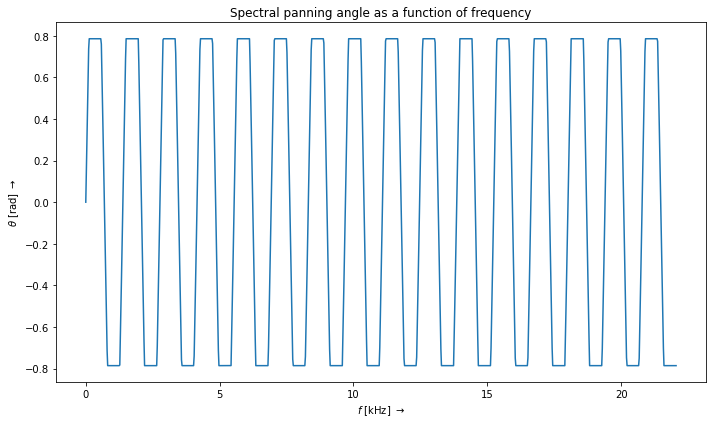

In [6]:
plt.figure(figsize=(10, 6))
plt.subplot(111)
plt.plot(n / s_win * FS / 1000, theta[:int(hs_win) + 1])
plt.title(r'Spectral panning angle as a function of frequency')
plt.xlabel(r'$f$ [kHz] $\rightarrow$')
plt.ylabel(r'$\theta$ [rad] $\rightarrow$')
plt.tight_layout()

In [7]:
pin = 0
pout = 0
pend = len(DAFx_in) - s_win

while (pin < pend):
    grain = DAFx_in[pin:(pin + s_win)] * wa
    f = np.fft.fft(grain)
    
    # compute left and right spectrum with Blumlein law at theta_l = 45° (loudspeakers)
    ftL = coef * f * (np.cos(theta) + np.sin(theta))
    ftR = coef * f * (np.cos(theta) - np.sin(theta))
    grainL = np.real(np.fft.ifft(ftL)) * ws
    grainR = np.real(np.fft.ifft(ftR)) * ws
    
    DAFx_out[pout:(pout + s_win), 0] += grainL
    DAFx_out[pout:(pout + s_win), 1] += grainR
    
    pin  = pin + na
    pout = pout + ns

In [8]:
DAFx_out = DAFx_out[s_win:(s_win + L)] * np.max(np.abs(DAFx_in))/ np.max(np.abs(DAFx_out))
print(DAFx_out.shape)
sf.write('audios/redwheel_stable.wav', DAFx_out, FS)

(109589, 2)


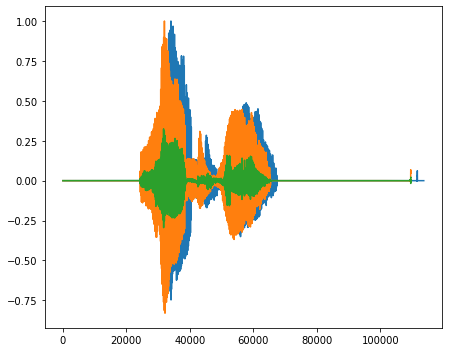

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(DAFx_in)
# plt.subplot(122)
plt.plot(DAFx_out)
plt.tight_layout()